In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split

In [47]:
# Loading the movies metadata Dataset

df = pd.read_csv('dataset/movies_metadata.csv', low_memory=False)
df

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [48]:
# Here we extract the realse Year of the movie from the entire DateTime , and if not there makes it NaN

df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
df['year'] 

0        1995
1        1995
2        1995
3        1995
4        1995
         ... 
45461     NaT
45462    2011
45463    2003
45464    1917
45465    2017
Name: year, Length: 45466, dtype: object

In [49]:
# Checking out what kind of Genres we have and filling out the empty genres with empty list ( It was Json previouesly )
df['genres'] = df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df['genres']

0         [Animation, Comedy, Family]
1        [Adventure, Fantasy, Family]
2                   [Romance, Comedy]
3            [Comedy, Drama, Romance]
4                            [Comedy]
                     ...             
45461                 [Drama, Family]
45462                         [Drama]
45463       [Action, Drama, Thriller]
45464                              []
45465                              []
Name: genres, Length: 45466, dtype: object

In [50]:
df

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[Drama, Family]",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,NaT
45462,False,NaN,0,[Drama],NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0,2011
45463,False,NaN,0,"[Action, Drama, Thriller]",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0,1917


In [51]:
# Getting the mean of the vote_averge and converting the vote_counts to int so it is easier to deal with 

vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [52]:
# Getting the 0.85 quantile of the vote counts

m = vote_counts.quantile(0.85)
m

82.0

In [53]:
# We select the movies which has the vote count of atleast the 0.95 quantile ( which is 434 ) and if it is below that we consider it not qualified
qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]

# We convert the type of the vote_count and vote_averge to int ( since we did that above so we will need to do that again to the new part of the dataset we made )
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(6832, 6)

In [54]:
# Gives weights to each movie depending on thier vote_count and thier vote_averge using some Formula 

def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']                
    return (v/(v+m) * R) + (m/(m+v) * C)  



In [55]:
# Applying the weight_rating function to the qualifted Movies

qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [56]:
# Printing the qualifed movies to check out the wr for them

qualified

,title,year,vote_count,vote_average,popularity,genres,wr
0,Toy Story,1995,5415,7,21.946943,"[Animation, Comedy, Family]",6.973819
1,Jumanji,1995,2413,6,17.015539,"[Adventure, Fantasy, Family]",5.975183
2,Grumpier Old Men,1995,92,6,11.7129,"[Romance, Comedy]",5.644147
4,Father of the Bride Part II,1995,173,5,8.387519,[Comedy],5.078751
5,Heat,1995,1886,7,17.924927,"[Action, Crime, Drama, Thriller]",6.926871
...,...,...,...,...,...,...,...
45268,"Good Guys Go to Heaven, Bad Guys Go to Pattaya",2016,153,5,5.613875,[Comedy],5.085453
45339,With Open Arms,2017,94,5,7.250495,[Comedy],5.114100
45343,The Visitors: Bastille Day,2016,167,4,7.29492,[Comedy],4.409966
45437,In a Heartbeat,2017,146,8,20.82178,"[Family, Animation, Romance, Comedy]",7.009129


In [57]:
# Sorting the movies upon thier wr 

qualified = qualified.sort_values('wr', ascending=False)

Top 10 Movies

In [58]:
# The top 10 movies with highest wr

qualified.head(10)

,title,year,vote_count,vote_average,popularity,genres,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,"[Comedy, Drama, Romance]",8.585574
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.984042
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.981708
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.979952
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.976853
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.974825
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.974187
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.973232
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.972807
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.972546


In [59]:
# Instead of having each movie having one row that has all genres we made it into mutliple rows so it is more friendly to deal with and then he droped the genres ( the one that has all o them in one row )

s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name= 'genre'
gen_df = df.drop('genres', axis=1).join(s)

In [60]:
# Building a simple Recommender which simply suggests the best movies of each genre you chose

def build_chart(genre, percentile=0.85):
    df = gen_df[gen_df['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(weighted_rating , axis = 1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

# Top 10 movies of the genre you choose

In [61]:
build_chart('Romance')

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.585574
351,Forrest Gump,1994,8147,8,48.307194,7.972546
876,Vertigo,1958,1162,8,18.20822,7.818394
40251,Your Name.,2016,1030,8,34.461252,7.796836
883,Some Like It Hot,1959,835,8,11.845107,7.753633
...,...,...,...,...,...,...
7582,How to Steal a Million,1966,133,7,12.389626,6.330612
6912,Beauty and the Beast,1946,133,7,4.798852,6.330612
24888,Remember Sunday,2013,131,7,11.190606,6.324326
2801,Body Heat,1981,128,7,5.991482,6.314674


In [62]:
# Loading the links Dataset

links = pd.read_csv('dataset/links_small.csv')

In [63]:
# Filtering out rows where tmdbId is (null) and converting the tmdbId column to integers

links = links[links['tmdbId'].notnull()]['tmdbId'].astype('int')

In [64]:
# Detect non numeric values in the 'budget' column
numeric_budgets = pd.to_numeric(df['budget'], errors='coerce')
non_numeric_budgets = df[numeric_budgets.isna()]

# Detect non numeric values in the id column
numeric_ids = pd.to_numeric(df['id'], errors='coerce')
non_numeric_ids = df[numeric_ids.isna()]

# Display rows with issues
print(non_numeric_budgets)
print(non_numeric_ids)

                                                   adult  \
19730                                 - Written by Ørnås   
29503   Rune Balot goes to a casino connected to the ...   
35587   Avalanche Sharks tells the story of a bikini ...   

      belongs_to_collection                            budget  \
19730              0.065736  /ff9qCepilowshEtG2GYWwzt2bs4.jpg   
29503              1.931659  /zV8bHuSL6WXoD6FWogP9j4x80bL.jpg   
35587              2.185485  /zaSf5OG7V8X8gqFvly88zDdRm46.jpg   

                                                  genres  \
19730  [Carousel Productions, Vision View Entertainme...   
29503  [Aniplex, GoHands, BROSTA TV, Mardock Scramble...   
35587  [Odyssey Media, Pulser Productions, Rogue Stat...   

                                                homepage          id imdb_id  \
19730  [{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...  1997-08-20       0   
29503  [{'iso_3166_1': 'US', 'name': 'United States o...  2012-09-29       0   
35587           [

In [65]:
df = df.drop([19730, 29503, 35587])

# Content Based Recommender

In [66]:
# Loading the credits and keywords Dataset

credits = pd.read_csv('dataset/credits.csv')
keywords = pd.read_csv('dataset/keywords.csv')

In [67]:
# Convert the id column in the keywords and credits to integers

keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')

In [68]:
# Convert the id column in the df to integers

df['id'] = df['id'].astype('int')

In [69]:
df.shape

(45463, 25)

In [70]:
# Merge the df with the credits and keywords on the id column

df = df.merge(credits, on='id')
df = df.merge(keywords, on='id')

In [71]:
df

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46623,False,NaN,0,"[Drama, Family]",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,NaT,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...","[{'id': 10703, 'name': 'tragic love'}]"
46624,False,NaN,0,[Drama],NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,Released,NaN,Century of Birthing,False,9.0,3.0,2011,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...","[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46625,False,NaN,0,"[Action, Drama, Thriller]",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",[]
46626,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,Released,NaN,Satan Triumphant,False,0.0,0.0,1917,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",[]


In [72]:
# Filter the df to include only rows where the id column's values are present in the links

sdf = df[df['id'].isin(links)]
sdf.shape

(9219, 28)

In [73]:
# Convert the string representation of lists in the cast, crew and keywords column into actual lists
sdf.loc[:, 'cast'] = sdf['cast'].apply(literal_eval)
sdf.loc[:, 'crew'] = sdf['crew'].apply(literal_eval)
sdf.loc[:, 'keywords'] = sdf['keywords'].apply(literal_eval)

# Create a new columns for cast_size and crew_size thats contains the number of elements in the cast and crew list for each row
sdf.loc[:,'cast_size'] = sdf['cast'].apply(lambda x: len(x))
sdf.loc[:,'crew_size'] = sdf['crew'].apply(lambda x: len(x))

C:\Users\medoo\AppData\Local\Temp\ipykernel_35124\717964689.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf.loc[:,'cast_size'] = sdf['cast'].apply(lambda x: len(x))
C:\Users\medoo\AppData\Local\Temp\ipykernel_35124\717964689.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf.loc[:,'crew_size'] = sdf['crew'].apply(lambda x: len(x))


In [74]:
# Create a function to extract the director name

def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [75]:
# Create a new column director that contains the name of the director for each movie

sdf['director'] = sdf['crew'].apply(get_director)

C:\Users\medoo\AppData\Local\Temp\ipykernel_35124\516768907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['director'] = sdf['crew'].apply(get_director)


In [76]:
sdf

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,video,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106,John Lasseter
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",26,16,Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",7,4,Howard Deutch
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",10,10,Forest Whitaker
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",12,7,Charles Shyer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45985,False,"{'id': 34055, 'name': 'Pokémon Collection', 'p...",0,"[Adventure, Fantasy, Animation, Science Fictio...",http://www.pokemon.com/us/movies/movie-pokemon...,12600,tt0287635,ja,劇場版ポケットモンスター セレビィ 時を越えた遭遇（であい）,"All your favorite Pokémon characters are back,...",...,False,5.7,82.0,2001,"[{'cast_id': 1, 'character': 'Ash Ketchum (voi...","[{'credit_id': '52fe45049251416c75048e35', 'de...","[{'id': 9663, 'name': 'sequel'}, {'id': 11451,...",4,17,Kunihiko Yuyama
46424,False,NaN,0,"[Comedy, Drama]",NaN,265189,tt2121382,sv,Turist,"While holidaying in the French Alps, a Swedish...",...,False,6.8,255.0,2014,"[{'cast_id': 2, 'character': 'Ebba', 'credit_i...","[{'credit_id': '534fd1a80e0a267eb6000e32', 'de...","[{'id': 293, 'name': 'female nudity'}, {'id': ...",9,15,Ruben Östlund
46425,False,NaN,0,"[Comedy, Drama]",NaN,265189,tt2121382,sv,Turist,"While holidaying in the French Alps, a Swedish...",...,False,6.8,255.0,2014,"[{'cast_id': 2, 'character': 'Ebba', 'credit_i...","[{'credit_id': '534fd1a80e0a267eb6000e32', 'de...","[{'id': 293, 'name': 'female nudity'}, {'id': ...",9,15,Ruben Östlund
46426,False,NaN,0,"[Comedy, Drama]",NaN,265189,tt2121382,sv,Turist,"While holidaying in the French Alps, a Swedish...",...,False,6.8,255.0,2014,"[{'cast_id': 2, 'character': 'Ebba', 'credit_i...","[{'credit_id': '534fd1a80e0a267eb6000e32', 'de...","[{'id': 293, 'name': 'female nudity'}, {'id': ...",9,15,Ruben Östlund


In [77]:
# Convert the cast column so that it contains only the names of the cast members
sdf.loc[:,'cast'] = sdf['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# Trim the cast list to include only the first three cast members
sdf.loc[:,'cast'] = sdf['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

# Convert each name in the cast column to lowercase and remove any spaces
sdf.loc[:,'cast'] = sdf['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [78]:
# Convert the keywords column so that it contains only the names of the keywords

sdf.loc[:,'keywords'] = sdf['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [79]:
# Convert the director column to string type, then converts the name to lowercase and removes any spaces
sdf.loc[:,'director'] = sdf['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))

# Mention Director 3 times to give it more weight relative to the entire cast.
sdf.loc[:,'director'] = sdf['director'].apply(lambda x: [x, x, x])

In [80]:
sdf

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,video,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,False,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106,"[johnlasseter, johnlasseter, johnlasseter]"
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,False,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",26,16,"[joejohnston, joejohnston, joejohnston]"
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,False,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger, o...",7,4,"[howarddeutch, howarddeutch, howarddeutch]"
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,False,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[based on novel, interracial relationship, sin...",10,10,"[forestwhitaker, forestwhitaker, forestwhitaker]"
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,False,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence, aging, daug...",12,7,"[charlesshyer, charlesshyer, charlesshyer]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45985,False,"{'id': 34055, 'name': 'Pokémon Collection', 'p...",0,"[Adventure, Fantasy, Animation, Science Fictio...",http://www.pokemon.com/us/movies/movie-pokemon...,12600,tt0287635,ja,劇場版ポケットモンスター セレビィ 時を越えた遭遇（であい）,"All your favorite Pokémon characters are back,...",...,False,5.7,82.0,2001,"[veronicataylor, rachaellillis, maddieblaustein]","[{'credit_id': '52fe45049251416c75048e35', 'de...","[sequel, pokémon, celebi]",4,17,"[kunihikoyuyama, kunihikoyuyama, kunihikoyuyama]"
46424,False,NaN,0,"[Comedy, Drama]",NaN,265189,tt2121382,sv,Turist,"While holidaying in the French Alps, a Swedish...",...,False,6.8,255.0,2014,"[lisalovenkongsli, johannesbahkuhnke, clarawet...","[{'credit_id': '534fd1a80e0a267eb6000e32', 'de...","[female nudity, dark comedy, family vacation, ...",9,15,"[rubenöstlund, rubenöstlund, rubenöstlund]"
46425,False,NaN,0,"[Comedy, Drama]",NaN,265189,tt2121382,sv,Turist,"While holidaying in the French Alps, a Swedish...",...,False,6.8,255.0,2014,"[lisalovenkongsli, johannesbahkuhnke, clarawet...","[{'credit_id': '534fd1a80e0a267eb6000e32', 'de...","[female nudity, dark comedy, family vacation, ...",9,15,"[rubenöstlund, rubenöstlund, rubenöstlund]"
46426,False,NaN,0,"[Comedy, Drama]",NaN,265189,tt2121382,sv,Turist,"While holidaying in the French Alps, a Swedish...",...,False,6.8,255.0,2014,"[lisalovenkongsli, johannesbahkuhnke, clarawet...","[{'credit_id': '534fd1a80e0a267eb6000e32', 'de...","[female nudity, dark comedy, family vacation, ...",9,15,"[rubenöstlund, rubenöstlund, rubenöstlund]"


In [81]:
# Extract and stack all keywords from the keywords column in 'sdf' into a single Series named keyword

s = sdf.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [82]:
# Count the occurrences of each keyword in the Series s and display the top 5 most common keywords based on their counts

s = s.value_counts()
s[:5]

keyword
independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: count, dtype: int64

In [83]:
# Filter the Series 's' to keep only keywords that occur more than once.

s = s[s > 1]

In [84]:
stemmer = SnowballStemmer('english')

In [85]:
# This function, filter_keywords, takes a list of keywords x as input and filters it to keep only those keywords that exist in the Series s

def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [86]:
# Apply the 'filter_keywords' function to the keywords column to retain only those that are present in the Series s
sdf.loc[:,'keywords'] = sdf['keywords'].apply(filter_keywords)

# Apply stemming to each keyword in the keywords column using the stemmer object to transform each keyword into its root form
sdf.loc[:,'keywords'] = sdf['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])

# Convert each keyword in the 'keywords' column to lowercase and remove any spaces.
sdf.loc[:,'keywords'] = sdf['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [87]:
sdf = sdf.copy()

# Combine the keywords, cast, director, and genres columns into a single column soup.
sdf['soup'] = sdf['keywords'] + sdf['cast'] + sdf['director'] + sdf['genres']

# Convert the list of elements in soup to a single space-separated string
sdf['soup'] = sdf['soup'].apply(lambda x: ' '.join(x))

In [88]:
# Initialize CountVectorizer to convert text data into a matrix of token counts (unigrams and bigrams), ignoring English stop words
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.0, stop_words='english')

# Fit the CountVectorizer to the soup column and transform it into a sparse matrix of word/token counts
count_matrix = count.fit_transform(sdf['soup']) 

In [89]:
# Compute the cosine similarity between the rows of the count matrix

cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [124]:
cosine_sim

array([[1.        , 0.02441931, 0.02738955, ..., 0.02135407, 0.02135407,
        0.02135407],
       [0.02441931, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02738955, 0.        , 1.        , ..., 0.02514977, 0.02514977,
        0.02514977],
       ...,
       [0.02135407, 0.        , 0.02514977, ..., 1.        , 1.        ,
        1.        ],
       [0.02135407, 0.        , 0.02514977, ..., 1.        , 1.        ,
        1.        ],
       [0.02135407, 0.        , 0.02514977, ..., 1.        , 1.        ,
        1.        ]])

In [90]:
# Reset the index of the DataFrame, creating a new default integer index and moving the old index to a column
sdf = sdf.reset_index()

# Extract the title column from the DataFrame and store it as a separate variable for later use
titles = sdf['title']

# Create a Pandas Series with movie titles as the index and their corresponding DataFrame indices as the values
indices = pd.Series(sdf.index, index=sdf['title'])

In [189]:
indices

title
Toy Story                                         0
Jumanji                                           1
Grumpier Old Men                                  2
Waiting to Exhale                                 3
Father of the Bride Part II                       4
                                               ... 
Pokémon 4Ever: Celebi - Voice of the Forest    9214
Force Majeure                                  9215
Force Majeure                                  9216
Force Majeure                                  9217
Force Majeure                                  9218
Length: 9219, dtype: int64

In [91]:
sdf

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director,soup
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousi, toy, boy, friendship, friend, rival...",13,106,"[johnlasseter, johnlasseter, johnlasseter]",jealousi toy boy friendship friend rivalri boy...
1,1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,...,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgam, disappear, basedonchildren'sbook, n...",26,16,"[joejohnston, joejohnston, joejohnston]",boardgam disappear basedonchildren'sbook newho...
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,...,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fish, bestfriend, duringcreditssting]",7,4,"[howarddeutch, howarddeutch, howarddeutch]",fish bestfriend duringcreditssting waltermatth...
3,3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,...,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[basedonnovel, interracialrelationship, single...",10,10,"[forestwhitaker, forestwhitaker, forestwhitaker]",basedonnovel interracialrelationship singlemot...
4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,...,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[babi, midlifecrisi, confid, age, daughter, mo...",12,7,"[charlesshyer, charlesshyer, charlesshyer]",babi midlifecrisi confid age daughter motherda...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9214,45985,False,"{'id': 34055, 'name': 'Pokémon Collection', 'p...",0,"[Adventure, Fantasy, Animation, Science Fictio...",http://www.pokemon.com/us/movies/movie-pokemon...,12600,tt0287635,ja,劇場版ポケットモンスター セレビィ 時を越えた遭遇（であい）,...,5.7,82.0,2001,"[veronicataylor, rachaellillis, maddieblaustein]","[{'credit_id': '52fe45049251416c75048e35', 'de...","[sequel, pokémon, celebi]",4,17,"[kunihikoyuyama, kunihikoyuyama, kunihikoyuyama]",sequel pokémon celebi veronicataylor rachaelli...
9215,46424,False,NaN,0,"[Comedy, Drama]",NaN,265189,tt2121382,sv,Turist,...,6.8,255.0,2014,"[lisalovenkongsli, johannesbahkuhnke, clarawet...","[{'credit_id': '534fd1a80e0a267eb6000e32', 'de...","[femalenud, darkcomedi, familyvac, avalanch, r...",9,15,"[rubenöstlund, rubenöstlund, rubenöstlund]",femalenud darkcomedi familyvac avalanch runnin...
9216,46425,False,NaN,0,"[Comedy, Drama]",NaN,265189,tt2121382,sv,Turist,...,6.8,255.0,2014,"[lisalovenkongsli, johannesbahkuhnke, clarawet...","[{'credit_id': '534fd1a80e0a267eb6000e32', 'de...","[femalenud, darkcomedi, familyvac, avalanch, r...",9,15,"[rubenöstlund, rubenöstlund, rubenöstlund]",femalenud darkcomedi familyvac avalanch runnin...
9217,46426,False,NaN,0,"[Comedy, Drama]",NaN,265189,tt2121382,sv,Turist,...,6.8,255.0,2014,"[lisalovenkongsli, johannesbahkuhnke, clarawet...","[{'credit_id': '534fd1a80e0a267eb6000e32', 'de...","[femalenud, darkcomedi, familyvac, avalanch, r...",9,15,"[rubenöstlund, rubenöstlund, rubenöstlund]",femalenud darkcomedi familyvac avalanch runnin...


In [92]:
def get_recommendations(title):
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    movies = sdf.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    m = vote_counts.quantile(0.60)
    
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [93]:
get_recommendations('The Dark Knight').head(10)

C:\Users\medoo\AppData\Local\Temp\ipykernel_35124\4286952062.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
C:\Users\medoo\AppData\Local\Temp\ipykernel_35124\4286952062.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
C:\Users\medoo\AppData\Local\Temp\ipykernel_35124\4286952062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

,title,vote_count,vote_average,year,wr
7608,Inception,14075,8,2010,7.984042
8573,Interstellar,11187,8,2014,7.979952
6587,The Prestige,4510,8,2006,7.950802
3373,Memento,4168,8,2000,7.946843
7991,The Dark Knight Rises,9263,7,2012,6.984599
6186,Batman Begins,7511,7,2005,6.981046
1122,Batman Returns,1706,6,1992,5.965370
132,Batman Forever,1529,5,1995,5.012465
9004,Batman v Superman: Dawn of Justice,7189,5,2016,5.002762
1252,Batman & Robin,1447,4,1997,4.066764


# Collaborative Filtering

In [94]:
# Loading the ratings Dataset

ratings = pd.read_csv('dataset/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [95]:
# Loading the Genrated ratings Dataset

ratings_gn = pd.read_csv('dataset/Genrated ratings Data.csv')
ratings_gn.head()

,userId,movieId,timestamp,rating
0,510,133730,849588178,2.097580
1,510,148672,846457615,3.033221
2,513,146590,851162656,2.529508
3,510,132772,846242746,2.091977
4,514,146968,833662076,0.333745


In [96]:
# Set the 'rating' values to 1 for all entries in 'ratings_gn' where the rating is less than 1
ratings_gn.loc[ratings_gn['rating'] < 1, 'rating'] = 1

# Set the 'rating' values to 5 for all entries in 'ratings_gn' where the rating is greater than 5.
ratings_gn.loc[ratings_gn['rating'] > 5, 'rating'] = 5

In [97]:
# Concatenate the 'ratings' DataFrame and the 'ratings_gn'
ratings_all = pd.concat([ratings, ratings_gn])

In [98]:
ratings_all

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
182987,624,142536,2.0,1473962172
182988,624,140725,3.0,1462187665
182989,624,144714,1.5,1474972061
182990,624,143257,2.5,1461356507


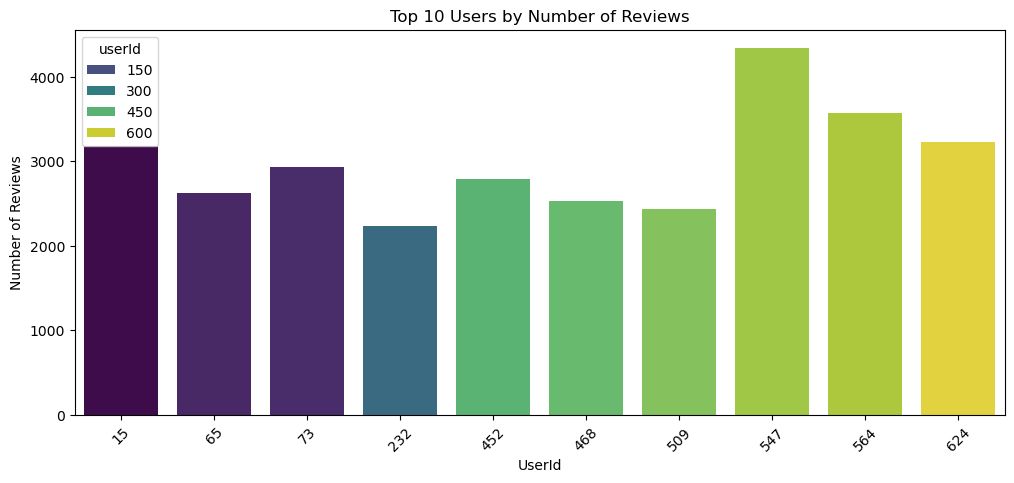

In [100]:
top_users = ratings_all['userId'].value_counts().head(10)
plt.figure(figsize=(12, 5))
sns.barplot(x=top_users.index, y=top_users.values, hue=top_users.index, palette='viridis', dodge=False)
plt.title('Top 10 Users by Number of Reviews')
plt.xlabel('UserId')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

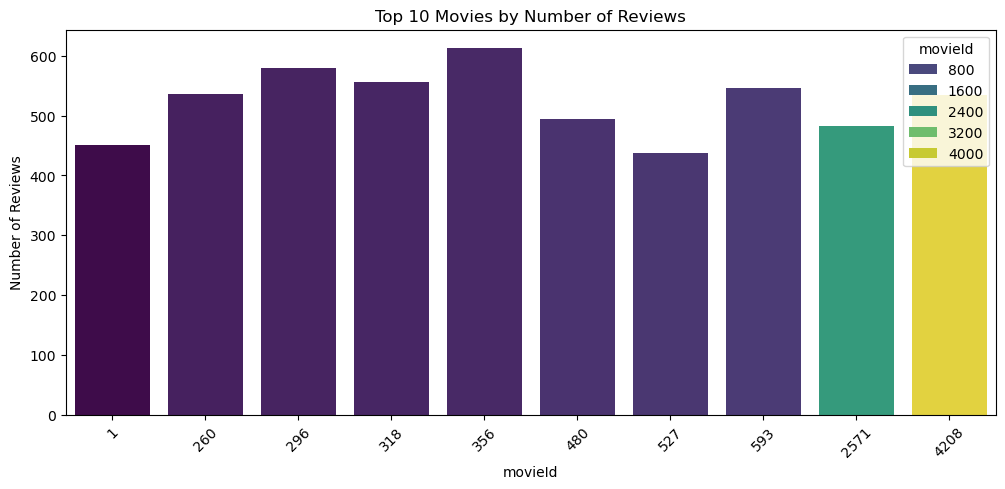

In [101]:
top_products = ratings_all['movieId'].value_counts().head(10)

plt.figure(figsize=(12, 5))
sns.barplot(x=top_products.index, y=top_products.values, hue=top_products.index, palette='viridis')
plt.title('Top 10 Movies by Number of Reviews')
plt.xlabel('movieId')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

In [102]:
# Convert the timestamp column from Unix time to a datetime format, then extract the Year and Month from the converted timestamps

ratings_all['timestamp'] = pd.to_datetime(ratings_all['timestamp'], unit='s')
ratings_all['Year'] = ratings_all['timestamp'].dt.year
ratings_all['Month'] = ratings_all['timestamp'].dt.month

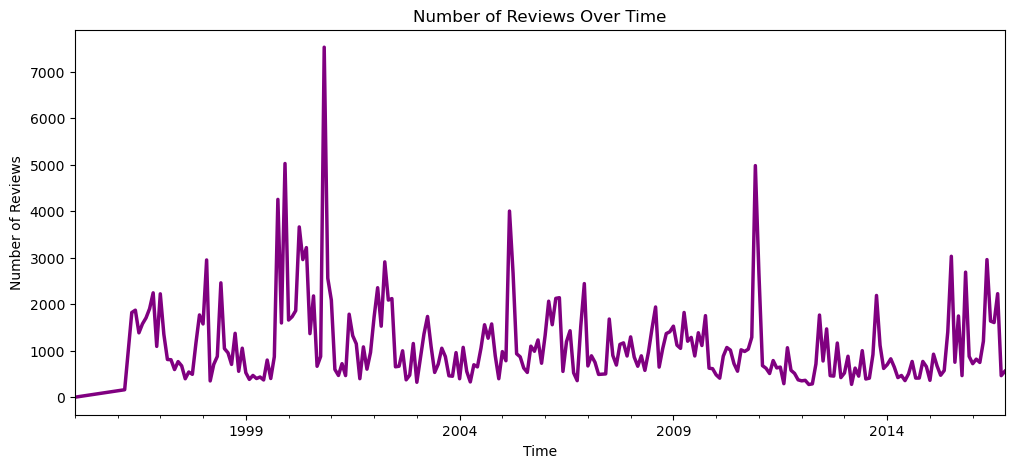

In [103]:
plt.figure(figsize=(12, 5))
ratings_all.groupby(ratings_all['timestamp'].dt.to_period('M')).size().plot(kind='line', linewidth =2.5, color='purple')
plt.title('Number of Reviews Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Reviews')
plt.show()

In [104]:
# Load the ratings data into a Surprise Dataset format, split it into training and testing sets, and fit an SVD model to the training data.
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings_all[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
model = SVD()
model.fit(trainset)

In [105]:
# Generate predictions using the trained SVD model on the test set and calculate the root mean square error (RMSE) to evaluate accuracy.

predictions = model.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9806


0.9805614711711558

In [106]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [107]:
model.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.28353541729269, details={'was_impossible': False})

In [108]:
# Convert the input x to an integer; if the conversion fails, return NaN.

def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [109]:
# Load a mapping of movie IDs from a CSV file, convert the 'tmdbId' to integers (replacing non-convertible values with NaN), 
id_map = pd.read_csv('dataset/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)

# rename columns for clarity, and merge with another DataFrame (sdf) on 'id' to create an index based on movie titles.
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(sdf[['title', 'id']], on='id').set_index('title')

In [163]:
id_map

,movieId,id
title,,
Toy Story,1,862.0
Jumanji,2,8844.0
Grumpier Old Men,3,15602.0
Waiting to Exhale,4,31357.0
Father of the Bride Part II,5,11862.0
...,...,...
The Last Brickmaker in America,161944,159550.0
Rustom,162542,392572.0
Mohenjo Daro,162672,402672.0


In [164]:
# Set the 'id' column as the index of the id_map DataFrame for easier access and lookup by 'id'.

indices_map = id_map.set_index('id')
indices_map

,movieId
id,
862.0,1
8844.0,2
15602.0,3
31357.0,4
11862.0,5
...,...
159550.0,161944
392572.0,162542
402672.0,162672


In [111]:
import joblib

# Save the CountVectorizer object
joblib.dump(count, 'model/count_vectorizer.pkl')

# Save the cosine similarity matrix
joblib.dump(cosine_sim, 'model/cosine_sim_matrix.pkl')

# Saving the model Weights 
joblib.dump(model, 'model/svd_recommender_model.pkl')

# Save the id_map and indices_map for later use
joblib.dump(id_map, 'model/id_map.pkl')
joblib.dump(indices_map, 'model/indices_map.pkl')
joblib.dump(indices, 'model/indices_series.pkl')

['model/indices_series.pkl']

In [134]:
def hybrid_recommendations(userId, title):
    title = str(title).title()
    idx = indices[title]
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = sdf.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: model.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [135]:
hybrid_recommendations(6, 'toy story 2')

,title,vote_count,vote_average,year,id,est
7589,Toy Story 3,4710.0,7.6,2010,10193,3.872356
7267,Up,7048.0,7.8,2009,14160,3.537492
0,Toy Story,5415.0,7.7,1995,862,3.532511
3279,The Brave Little Toaster,94.0,6.8,1987,19933,3.375434
8555,The Lego Movie,3127.0,7.5,2014,137106,3.342670
1875,A Bug's Life,2379.0,6.8,1998,9487,3.335198
8722,The Boxtrolls,689.0,6.6,2014,170687,3.188271
5255,"Bon Voyage, Charlie Brown (and Don't Come Back!)",12.0,6.2,1980,31112,3.178340
4317,"The Looney, Looney, Looney Bugs Bunny Movie",13.0,6.6,1981,41394,3.165423
6464,Cars,3991.0,6.6,2006,920,3.132247
